In [1]:
!unzip -q '/content/drive/MyDrive/BE_project/test_data.zip'

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
#tf.compat.v1.disable_v2_behavior()

1 Physical GPUs, 1 Logical GPUs


In [6]:
%cd /content/drive/MyDrive/super-resolution
#%cd /content/super-resolution

/content/drive/MyDrive/super-resolution


In [7]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Add, Concatenate, Multiply
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.preprocessing.image import img_to_array,ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

from model.srgan import generator

import numpy as np
from PIL import Image
import os 
import time
import matplotlib.pyplot as plt
import csv

import pandas as pd


In [3]:
TEST_PATH = '/content/test_data'

In [11]:
test = ImageDataGenerator(
    rescale= 1./255,
)

test_generator = test.flow_from_directory(
    TEST_PATH,
    class_mode=None,
    color_mode="rgb",
    batch_size=1,
    target_size=(64,64),
    seed=None,
    shuffle=False
)

Found 500 images belonging to 1 classes.


In [4]:
def load_image1(path):
    image_file = Image.open(path)
    zat2=image_file.resize((64,64))
    image = np.array(zat2)
    if(len(image.shape) == 2):
      image = np.stack((image,)*3, axis=-1)
    if(image.shape[2] == 4):
      image = image[:,:,:3]
    image = np.expand_dims(image, axis=0)
    return image

In [8]:
# model = generator()


# model.load_weights('/content/drive/MyDrive/SR-GAN_generator.h5')

# model.save('/content/drive/MyDrive/SR-GAN_generator_sample.h5')

model = load_model('/content/drive/MyDrive/SR-GAN_generator_sample.h5', compile = False)

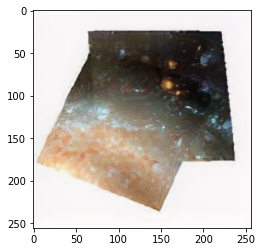

In [9]:
img = load_image1('/content/test_data/test/image_4234.png')
gen = model.predict(img)

plt.imshow(gen[0]/255)

In [10]:
predictions = []

path = '/content/test_data/test/'

test_dir = os.listdir(path)

steps = len(test_dir)

progbar = tf.keras.utils.Progbar(steps)
step = 1

for image in test_dir:

  im = load_image1(os.path.join(path,image))
  preds = model.predict(im)
  predictions.append(preds[0]/255)

  if(step<steps):
    progbar.update(step)
  step+=1

499/500 [============================>.] - ETA: 0s

In [11]:
predictions = np.array(predictions)

In [12]:
predictions.shape

(500, 256, 256, 3)

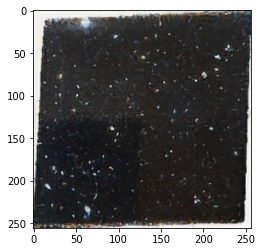

In [13]:
plt.imshow(predictions[0])

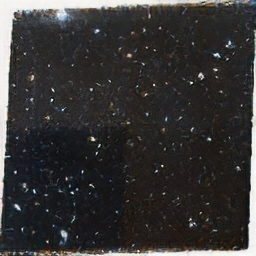

In [14]:
im = Image.fromarray((predictions[0]*255).astype(np.uint8))
im

In [15]:
test_dir[0]

'image_4582.png'

In [16]:
for img, name in zip(predictions,test_dir):
  im = Image.fromarray((img*255).astype(np.uint8))
  im.save(f"/content/drive/MyDrive/BE_project/SRGANoutput/testing/output_SRGAN_pretrained/{name}")